In [57]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

## Main idea
We have some stories that start national, and we want to know what could influence national starting stories. Mostly in terms of content

In [46]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

merged = pd.read_csv(IN_PATH, sep="\t")

In [ ]:
merged =  merged.dropna(subset=["clustNum"])

#look at which outlet first started a story 
#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])

In [62]:
docCols = ["index", "key"] + ["Topic" + str(i) for i in range(40)]

#get our topics in the mix 
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/doc_topics.txt", sep="\t", names=docCols)

In [63]:
merged = pd.merge(merged, docTopics, on="key", how="left")

In [64]:
cols = ["key", "source", "title", "content", "clustNum", "date", "national"] + ["Topic" + str(i) for i in range(40)]

#group data together 
grouped = merged[cols].groupby(by="clustNum").agg(list)
grouped["clustLen"] = grouped["key"].apply(len)

#get first to publish within a cluster 
grouped["first"] = grouped["date"].apply(lambda x: x.index(min(x)))

In [65]:
grouped["nationalFirst"] = grouped.apply(lambda x: x["national"][x["first"]], axis=1)

In [66]:
groupedSample = grouped.sample(20000)

In [67]:
def seriesMean(inSeries): 
    return [np.nanmean(clustList) for clustList in inSeries] 

topicCols = ["Topic" + str(i) for i in range(40)]

groupedSample[topicCols] = groupedSample[topicCols].apply(seriesMean, axis=1, result_type="expand")

<ipython-input-67-016928166177>:2: RuntimeWarning: Mean of empty slice
  return [np.nanmean(clustList) for clustList in inSeries]


In [68]:
groupedSample["natProp"] = groupedSample["national"].apply(np.mean)

In [69]:
groupedSample.columns

Index(['key', 'source', 'title', 'content', 'date', 'national', 'Topic0',
       'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7',
       'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13',
       'Topic14', 'Topic15', 'Topic16', 'Topic17', 'Topic18', 'Topic19',
       'Topic20', 'Topic21', 'Topic22', 'Topic23', 'Topic24', 'Topic25',
       'Topic26', 'Topic27', 'Topic28', 'Topic29', 'Topic30', 'Topic31',
       'Topic32', 'Topic33', 'Topic34', 'Topic35', 'Topic36', 'Topic37',
       'Topic38', 'Topic39', 'clustLen', 'first', 'nationalFirst', 'natProp'],
      dtype='object')

In [71]:
regressStr = "nationalFirst ~ natProp + " + " + ".join(topicCols)

In [82]:
groupedSample["nationalFirst"] = groupedSample["nationalFirst"].astype(int)

In [83]:
mod = smf.ols(regressStr, data=groupedSample).fit()

In [130]:
#mod.summary()

In [120]:
pvals = pd.DataFrame(mod.pvalues, columns=["pValues"]).reset_index()
params = pd.DataFrame(mod.params, columns=["params"]).reset_index()

resultsDf = pd.merge(pvals, params, on="index")
#resultsDf["pValues"] = resultsDf["pValues"].astype(float)
#resultsDf["params"] = resultsDf["params"].astype(float)
resultsDf = resultsDf[(resultsDf["index"] != "natProp") & (resultsDf["index"] != "Intercept") & (resultsDf["pValues"] <= .5)].sort_values("params")

In [121]:
topicWords = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/topic_keys.txt", sep="\t", names=["topicNum", "rand", "words"])
topicWords.head()

,topicNum,rand,words
0,0,0.125,league season club united players team game ba...
1,1,0.125,cases covid deaths county state health number ...
2,2,0.125,game season team games players play coach foot...
3,3,0.125,water park animals river lake area dog animal ...
4,4,0.125,die der und das den von mit ist nicht sich auf...


In [123]:
import re
def getTopicNum(inStr): 
    cleanStr = inStr.split(":")[0]
    return re.sub("[^0-9]", "", cleanStr)

resultsDf["topicNum"] = resultsDf["index"].apply(getTopicNum).astype(int)

In [124]:
topicsMerged = pd.merge(resultsDf, topicWords, on="topicNum", how="left").drop(columns=["rand"])
topicsMerged.head(10)

,index,pValues,params,topicNum,words
0,Topic22,1.879710e-08,-0.099368,22,israel government people country israeli minis...
1,Topic27,2.405561e-08,-0.079662,27,people time don family n't back life day told ...
2,Topic12,1.076639e-05,-0.079066,12,police officers protests protesters city floyd...
3,Topic20,2.723043e-19,-0.075942,20,police man officers year-old county arrested o...
4,Topic2,6.123424e-13,-0.058750,2,game season team games players play coach foot...
5,Topic31,1.836112e-04,-0.058243,31,people state masks coronavirus social health d...
6,Topic1,7.292947e-02,-0.039199,1,cases covid deaths county state health number ...
7,Topic13,1.710523e-01,-0.035755,13,it’s don’t time people we’re that’s make i’m w...
8,Topic36,7.220147e-02,-0.034175,36,investigation case fbi department attorney int...
9,Topic30,1.559344e-01,-0.028037,30,fire california san a.m p.m argus/dispatch ang...


In [128]:
topicsMerged.tail(10)

,index,pValues,params,topicNum,words
22,Topic18,8.190789e-02,0.029177,18,home time make buy room good hair day made bac...
23,Topic15,9.843526e-03,0.031198,15,iran russia russian military u.s forces war ir...
24,Topic8,1.500632e-02,0.036573,8,trump president biden white house donald admin...
25,Topic4,4.362958e-01,0.037105,4,die der und das den von mit ist nicht sich auf...
26,Topic39,3.109983e-03,0.047587,39,vaccine covid virus coronavirus people health ...
27,Topic32,4.499190e-03,0.052925,32,health study cancer treatment patients body me...
28,Topic33,3.584712e-03,0.054146,33,court law supreme federal justice state judge ...
29,Topic11,1.894980e-03,0.054920,11,news media twitter facebook video social post ...
30,Topic23,7.823468e-10,0.086209,23,people world political power america governmen...
31,Topic5,7.845616e-08,0.089679,5,government people johnson lockdown london mini...


In [126]:
mod = smf.ols("nationalFirst ~ natProp", data=groupedSample).fit()

In [127]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          nationalFirst   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                 1.179e+05
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:33:24   Log-Likelihood:                 5624.8
No. Observations:               20000   AIC:                        -1.125e+04
Df Residuals:                   19998   BIC:                        -1.123e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0503      0.002    -21.023      0.000      -0.055      -0.046
natProp        1.0209      0.003    343.355      0.000       1.015       1.027
==============================================================================
Omnibus:                     7234.184   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55978.205
Skew:                          -1.533   Prob(JB):                         0.00
Kurtosis:                      10.601   Cond. No.                         3.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

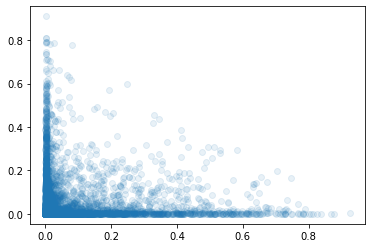

In [134]:
# maybe do some exploratory work to see if we can visualize this? 
import matplotlib.pyplot as plt
plt.scatter(groupedSample["Topic39"], groupedSample["Topic1"], alpha = .1)

In [152]:
hasBoth = (groupedSample["national"].apply(sum) != groupedSample["national"].apply(len)) & (groupedSample["national"].apply(sum) != 0)

In [153]:
groupedSample["hasBoth"] = hasBoth

(0.0, 0.5)

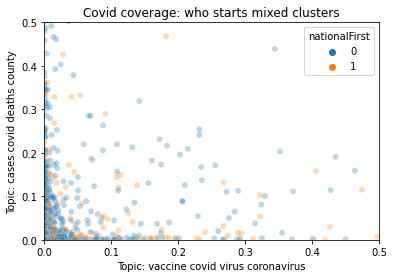

In [159]:
import seaborn as sns

mixedClusts = groupedSample[groupedSample["hasBoth"] == True]

# Use the 'hue' argument to provide a factor variable
sns.scatterplot( x="Topic39", y="Topic1", data=mixedClusts, hue='nationalFirst', legend=True, alpha=.3)
plt.title("Covid coverage: who starts mixed clusters")
plt.xlabel("Topic: vaccine covid virus coronavirus")
plt.ylabel("Topic: cases covid deaths county")

plt.xlim(0, .5)
plt.ylim(0, .5)

In [181]:
groupedSample["Topic1Bins"] = pd.cut(groupedSample["Topic1"], bins=[0, .2, .4, .6, .8])

<AxesSubplot:xlabel='nationalFirst', ylabel='Topic1Bins'>

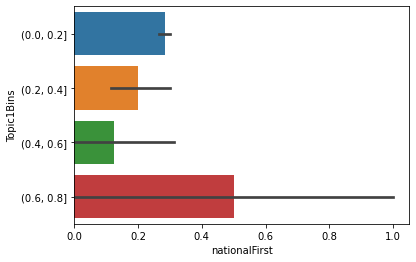

In [185]:
mixedClusts = groupedSample[groupedSample["hasBoth"] == True]
sns.barplot(x="nationalFirst", y="Topic1Bins", data=mixedClusts)

In [191]:
groupedSample["Topic39Bins"] = pd.cut(groupedSample["Topic39"], bins=[0, .2, .4, .6, .8])

<AxesSubplot:xlabel='nationalFirst', ylabel='Topic39Bins'>

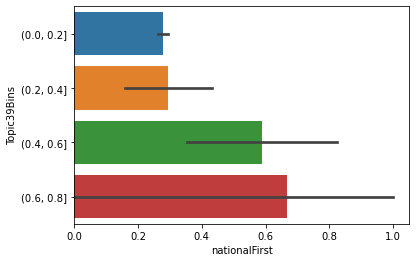

In [192]:
mixedClusts = groupedSample[groupedSample["hasBoth"] == True]
sns.barplot(x="nationalFirst", y="Topic39Bins", data=mixedClusts)